# Setup:

You can ignore pretty much all of this.

In [1]:
"""
Preable for most code and jupyter notebooks
@author: tobinsouth
"""

import numpy as np, pandas as pd

import math, string, nltk, re, pickle, time

from nltk.tokenize import RegexpTokenizer

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
plt.rcParams['savefig.dpi'] = 150

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"

In [2]:
import requests
from bs4 import BeautifulSoup
from collections import Counter

# Downloading

## Getting a list of all marvel movie scripts

In [3]:
url_marvel = "https://transcripts.fandom.com/wiki/Category:Marvel_Transcripts"

In [4]:
response = requests.get(url_marvel)

In [5]:
soup = BeautifulSoup(response.text, "html.parser")

In [6]:
url_endings = []
for link in soup.select('.category-page__member-link'):
    ending = link.get('href')
    if "Category" not in ending:
        url_endings.append(ending)

In [36]:
url_endings

['/wiki/Agents_of_S.H.I.E.L.D.',
 '/wiki/The_Amazing_Spider-Man_2',
 '/wiki/Ant-Man',
 '/wiki/Ant-Man_and_the_Wasp',
 '/wiki/Avengers_Assemble',
 '/wiki/The_Avengers',
 '/wiki/Avengers:_Age_of_Ultron',
 '/wiki/Avengers:_Age_of_Ultron:_Special_Edition',
 '/wiki/Avengers:_Endgame',
 '/wiki/Avengers:_Infinity_War',
 '/wiki/Black_Panther',
 '/wiki/Blade',
 '/wiki/Blade_II',
 '/wiki/Blade_Trinity_Alternate_Ending',
 '/wiki/Blade:_Trinity',
 '/wiki/Captain_America:_Civil_War',
 '/wiki/Captain_America:_The_First_Avenger',
 '/wiki/Captain_America:_The_Winter_Soldier',
 '/wiki/Captain_Marvel_(2019)',
 '/wiki/Deadpool_(film)',
 '/wiki/Deadpool_2',
 '/wiki/Doctor_Strange',
 '/wiki/Doomed',
 '/wiki/Fred_And_Barney_Meet_the_Thing',
 '/wiki/Guardians_of_the_Galaxy',
 '/wiki/Guardians_of_the_Galaxy_Vol._2',
 '/wiki/Spider-Man:_Homecoming',
 '/wiki/Hulk',
 '/wiki/Hulk_and_the_Agents_of_S.M.A.S.H.',
 '/wiki/Hulk_Teaser_Trailer',
 '/wiki/Hulk:_Bruce_Calling_Betty',
 '/wiki/Hulk:_Nanomed_Presentation',
 

## Scraping Infinity Saga Transcripts

In [33]:
my_list = [ # Comments are missing due to bad formatting. May have to write seperate systems to download these.
 '/wiki/Ant-Man',
 '/wiki/Ant-Man_and_the_Wasp',
 '/wiki/The_Avengers',
 '/wiki/Avengers:_Age_of_Ultron',
#  '/wiki/Avengers:_Endgame',
 '/wiki/Avengers:_Infinity_War',
 '/wiki/Black_Panther',
 '/wiki/Captain_America:_Civil_War',
 '/wiki/Captain_America:_The_First_Avenger',
 '/wiki/Captain_America:_The_Winter_Soldier',
 '/wiki/Captain_Marvel_(2019)',
 '/wiki/Doctor_Strange',
 '/wiki/Guardians_of_the_Galaxy',
 '/wiki/Guardians_of_the_Galaxy_Vol._2',
 '/wiki/Spider-Man:_Homecoming',
 '/wiki/Iron_Man',
 '/wiki/Iron_Man_2',
 '/wiki/Iron_Man_3',
#  '/wiki/The_Incredible_Hulk',
#  '/wiki/Thor',
 '/wiki/Thor:_Ragnarok',
 '/wiki/Thor:_The_Dark_World',]

Movies missing from infinity saga:

    hulk
    thor
    endgame

In [129]:
def get_char_seq(url):
    """ 
    Function to scrape the speaker from transcipts on 
    https://transcripts.fandom.com/
    Transcript have to have lines starting with a chacrter name followed by a ':'.
    Does not work on some scripts.
    @param url: The exact url of the transcript needing scraping.
    """
    response = requests.get(url)

    soup = BeautifulSoup(response.text, "html.parser")

    body = soup.select('#mw-content-text')[0]
    lines = body.text.split('\n')

    script_characters = []
    for line in lines:
        line = line.replace(u'\xa0', u'') # Removes non-breaking spaces, which was causing issues
        clean_line = re.sub(r"\[(.*)\]", " ", line) # Remove [stuff] which is usual extra content
        clean_line = re.sub(r"\((.*)\)", " ", clean_line) # Remove (stuff)
        start_matches = re.findall( "^(.*?):", clean_line) 
        
        if len(start_matches) == 1: # This many deals with the case that there are no matches
            finding = start_matches[0]
            finding = finding.lower()
#             finding = finding.lstrip().rstrip() # This is an alternative if you dont wnt to remove all spaces
            finding = ''.join([i for i in finding if i.isalpha()])
            if len(finding) < 21 and len(finding)!=0:
                script_characters.append(finding)
            
    script_characters = script_characters[2:] # Remove 'Next Transcript' and 'Previous Transcript'
    
    return script_characters

Running all code

In [84]:
counts = {} # Stores a list of tuples with (name, amount of lines)
seqs = {} # Stores the sequence of script allocations in order
for url in my_list:
    long_url = "https://transcripts.fandom.com/"+url
    seq = get_char_seq(long_url)
    counts[url] = (Counter(seq).most_common())
    seqs[url[6:]] =  seq

## Using Matt's Alias'

In [142]:
matt_git_csv = 'https://raw.githubusercontent.com/mroughan/AlephZeroHeroesData/master/MarvelCinematicUniverse/alias_list.csv'
matts_alias = pd.read_csv(matt_git_csv)

In [267]:
name_to_alias = {}
alias_to_name = {}
for i, row in matts_alias.iterrows():
    alias_list = row.Aliases.split(',')
    name_to_alias[row.Character] = alias_list
    
    # More importantly, to map between my data and Matt's
    for alias in alias_list:
        steralised_alias = ''.join([i for i in alias.lower() if i.isalpha()])
        alias_to_name[steralised_alias] = row.Character

## Adding to Matts Database

In [268]:
alias_to_name['peter'] = 'Spider-Man'
alias_to_name['tony'] = 'Iron Man'
alias_to_name['carol'] = 'Captain Marvel'
alias_to_name['pepper'] = 'Pepper Potts'
alias_to_name['toomes'] = 'Vulture'
alias_to_name['rocketraccoon'] = 'Rocket' # Note the double 'c'
alias_to_name['justin'] = 'Justin Hammer'
alias_to_name['scott'] = 'Ant-Man'
alias_to_name['natasha'] = 'Black Widow'
alias_to_name['natalie'] = 'Black Widow'
alias_to_name['hank'] = 'Pym'

alias_to_name['karen'] = 'Karen' # Spidey suit AI
alias_to_name['suitlady'] = 'Karen'

alias_to_name['may'] = 'May Parker' # Aunt May
alias_to_name['mason'] = 'Phineas Mason' # Spider-man tinkerer
alias_to_name['ivan'] = 'Whiplash'
alias_to_name['maria'] = 'Maria Hill' # Could be 'Maria Stark' but less likely to have dialogue

alias_to_name['talos'] = 'Talos'
alias_to_name['sohlarr'] = 'Talos' # Soh-Larr for you database
alias_to_name['keller'] = 'Talos'  # Keller
alias_to_name['generaltalos'] = 'Talos'
alias_to_name['christine'] = 'Dr. Christine Palmer' # Either 'Christine Everhart' or 'Dr. Christine Palmer'
alias_to_name['stern'] = 'Senator Stern' # 'Dr. Samuel Sterns' or 'Senator Stern' by we don't have Hulk so..
alias_to_name['nakia'] = 'Nakia' # From black panther
alias_to_name['aaron'] = 'Aaron Davis' # Also 'Prowler' or 'The Prowler' for your database
alias_to_name['ianboothby'] = 'Ian Boothby' # Also The Intern, Mr. Selvig, from Thor: Dark World
alias_to_name['monica'] = 'Monica Rambeau' # Daughter in Captain Marvel
alias_to_name['steve'] = 'Captain America'
alias_to_name['brice'] = 'Shocker 1'
alias_to_name['michelle'] = 'Michelle Jones'
alias_to_name['banner'] = 'Hulk'
alias_to_name['corpsmandey'] = 'Rhomann Dey'
alias_to_name['eitri'] = 'Eitri'
alias_to_name['lawson'] = 'Mar-Vell' # Also Wendy Lawson
alias_to_name['secretaryross'] = 'Thaddeus Ross'
alias_to_name['darrencross'] = 'Darren Cross'
alias_to_name['liz'] = 'Liz Allan' # Brand new in your database, from villians daughter Spiderman 

## Using Alias

In [269]:
clean_seqs = {}
failed_names = []
for movie_name, seq in seqs.items():
    new_seq = [] # Make a new array to preserve data in memory
    for line in seq:
        if line in alias_to_name:
            new_seq.append(alias_to_name[line])
        else:
            new_seq.append(line)
            failed_names.append(line) # Save everything that we don't catch to update Matt's list
    clean_seqs[movie_name] = new_seq

In [270]:
Counter(failed_names).most_common()

[('richard', 24),
 ('man', 22),
 ('director', 15),
 ('shieldagent', 15),
 ('ayesha', 15),
 ('newsanchor', 14),
 ('furyscar', 14),
 ('kraglinobfonteri', 14),
 ('kid', 13),
 ('frenchpirate', 13),
 ('shieldcomputer', 13),
 ('doris', 13),
 ('policeofficer', 13),
 ('soldier', 12),
 ('dale', 11),
 ('curator', 11),
 ('vasilykarpov', 11),
 ('senatorbrandt', 11),
 ('novaprime', 11),
 ('stakarogord', 11),
 ('charles', 11),
 ('dumdumdugan', 10),
 ('doctor', 10),
 ('wendylawson', 10),
 ('abe', 10),
 ('councilmanrockwell', 9),
 ('minnerva', 9),
 ('newsreporter', 9),
 ('denariansaal', 9),
 ('jane', 9),
 ('mitchellcarson', 8),
 ('gabejones', 8),
 ('jimmorita', 8),
 ('bronchar', 8),
 ('skrullscientist', 8),
 ('rhodes', 8),
 ('janet', 7),
 ('councilmember', 7),
 ('boy', 7),
 ('militant', 7),
 ('woman', 7),
 ('automatedvoice', 7),
 ('towerkeeper', 7),
 ('fdoctor', 7),
 ('youngdoctor', 7),
 ('general', 7),
 ('comtech', 7),
 ('billy', 7),
 ('drwest', 7),
 ('marshal', 7),
 ('woo', 6),
 ('guard', 6),
 ('zur

## Saving to CSVs

In [273]:
for name, seq in clean_seqs.items():
    series = pd.Series(seq)
    series.to_csv('../Data/MarvelScripts/'+name+'.csv')

## Making new counts

In [276]:
counts = {}
for name, seq in clean_seqs.items():
    counts[name] = (Counter(seq).most_common())

# Calculations 

## Running Shannon Entropy

In [278]:
shannon_entropys = {}
for name, count_list in counts.items():
    total = np.sum([person[1] for person in count_list])
    shannon_entropy = 0
    for person in count_list:
        p = person[1]/total
        shannon_entropy+= p*math.log(p,2)
        
    shannon_entropys[name] = -shannon_entropy

pd.Series(shannon_entropys)

Ant-Man                                3.417108
Ant-Man_and_the_Wasp                   2.839550
The_Avengers                           3.613574
Avengers:_Age_of_Ultron                3.972530
Avengers:_Infinity_War                 4.701289
Black_Panther                          4.161447
Captain_America:_Civil_War             4.205957
Captain_America:_The_First_Avenger     4.202498
Captain_America:_The_Winter_Soldier    3.957675
Captain_Marvel_(2019)                  3.551525
Doctor_Strange                         2.970114
Guardians_of_the_Galaxy                3.654280
Guardians_of_the_Galaxy_Vol._2         3.671391
Spider-Man:_Homecoming                 3.893126
Iron_Man                               2.399423
Iron_Man_2                             3.424611
Iron_Man_3                             3.107960
Thor:_Ragnarok                         4.116729
Thor:_The_Dark_World                   3.896791
dtype: float64


## Diversity Index

" [Diversity index](https://en.wikipedia.org/wiki/Diversity_index) is a quantitative measure that reflects how many different types (such as species) there are in a dataset (a community), and simultaneously takes into account how evenly the basic entities (such as individuals) are distributed among those types. "

$$
^{q} D=\frac{1}{M_{q-1}} = \left(\sum_{i=1}^{R} p_{i}^{q}\right)^{1 /(1-q)}
$$

with $M_{q-1}$ as weighted generalized mean with exponent q-1

$$
^{1} D=\frac{1}{\prod_{i=1}^{R} p_{i}^{p_{i}}}=\exp \left(-\sum_{i=1}^{R} p_{i} \ln \left(p_{i}\right)\right)
$$


"In other domains, this ($^{1} D$) statistic is also known as the perplexity."

In [279]:
diversities = {} # Using D1, we just take exp(shannon entropy)
for name, en in shannon_entropys.items():
    diversities[name]  = np.exp(en)
    
pd.Series(diversities)

Ant-Man                                 30.481131
Ant-Man_and_the_Wasp                    17.108066
The_Avengers                            37.098419
Avengers:_Age_of_Ultron                 53.118777
Avengers:_Infinity_War                 110.088961
Black_Panther                           64.164283
Captain_America:_Civil_War              67.084757
Captain_America:_The_First_Avenger      66.853114
Captain_America:_The_Winter_Soldier     52.335484
Captain_Marvel_(2019)                   34.866434
Doctor_Strange                          19.494145
Guardians_of_the_Galaxy                 38.639702
Guardians_of_the_Galaxy_Vol._2          39.306534
Spider-Man:_Homecoming                  49.064031
Iron_Man                                11.016814
Iron_Man_2                              30.710691
Iron_Man_3                              22.375354
Thor:_Ragnarok                          61.358229
Thor:_The_Dark_World                    49.244195
dtype: float64

## Entropy Rates

In [280]:
def hhat(list_of_string):
    """ Non parametric entropy rate estimator for a single random process. """
    word_set = set(list_of_string)

    ref = dict(zip(word_set, list(range(len(word_set)))))

    data = [ref[w] for w in list_of_string]

    N = len(data)
    Lambdas = 0
    pre_string = "  "  # Create a string containing the previous words
    for i in range(N):  
        count = 0
        string_in = True 
        while string_in and i+count<N: # Loop through each possible subsequence until break
            count+=1
            string_in = " " + " ".join([str(i) for i in data[i:i+count]]) + " " in pre_string  # Use 'in' to check
        Lambdas += count
        pre_string += "%s  " % data[i]  # Append to previous words varible
    return N*math.log(N,2)/Lambdas

In [281]:
entropy_rates = {}
for name, seq in seqs.items():
    entropy_rates[name] = hhat(seq)
    
pd.Series(entropy_rates)

Ant-Man                                4.992226
Ant-Man_and_the_Wasp                   3.916968
The_Avengers                           4.110046
Avengers:_Age_of_Ultron                5.065948
Avengers:_Infinity_War                 5.119006
Black_Panther                          4.425484
Captain_America:_Civil_War             5.093364
Captain_America:_The_First_Avenger     4.956875
Captain_America:_The_Winter_Soldier    5.013246
Captain_Marvel_(2019)                  4.831153
Doctor_Strange                         4.012015
Guardians_of_the_Galaxy                4.732865
Guardians_of_the_Galaxy_Vol._2         4.852244
Spider-Man:_Homecoming                 5.444263
Iron_Man                               3.753117
Iron_Man_2                             5.126537
Iron_Man_3                             4.704346
Thor:_Ragnarok                         3.636364
Thor:_The_Dark_World                   4.910339
dtype: float64

# Combining Results

Making a dataframe of my work

In [337]:
df = pd.DataFrame()
df['entropy_rate'] = pd.Series(entropy_rates)
df['diversity'] = pd.Series(diversities)
df['shannon_entropy'] = pd.Series(shannon_entropys)

Getting Matt's meta data

In [338]:
matt_imdb_meta = pd.read_csv(
    'https://raw.githubusercontent.com/mroughan/AlephZeroHeroesData/master/MarvelCinematicUniverse/imdb_data.csv')

### Aligning DataFrame Index

In [339]:
df['Transcript URL Tail'] = df.index

In [340]:
df['Index'] = [''.join([i for i in d.lower() if i.isalnum()]) for d in df.index]
df['Index']= ['captainmarvel' if 'captainmarvel' in i else i for i in df.Index ]

In [342]:
index_matt = [''.join([i for i in d.lower() if i.isalnum()]) for d in matt_imdb_meta.Title]
matt_imdb_meta['Index'] =  index_matt

### Merging Dataframes

In [345]:
df = pd.merge(df, matt_imdb_meta, on = 'Index')

In [346]:
df

,entropy_rate,diversity,shannon_entropy,Transcript URL Tail,Index,Title,ReleaseYear,IMDBid,Runtime,imdbRating,imdbVotes,Metascore
0,4.992226,30.481131,3.417108,Ant-Man,antman,Ant-Man,2015.0,tt0478970,117.0,7.3,470894.0,64.0
1,3.916968,17.108066,2.839550,Ant-Man_and_the_Wasp,antmanandthewasp,Ant-Man and the Wasp,2018.0,tt5095030,118.0,7.1,191018.0,70.0
2,4.110046,37.098419,3.613574,The_Avengers,theavengers,The Avengers,2012.0,tt0848228,143.0,8.1,1144824.0,69.0
3,5.065948,53.118777,3.972530,Avengers:_Age_of_Ultron,avengersageofultron,Avengers: Age of Ultron,2015.0,tt2395427,141.0,7.4,627597.0,66.0
4,5.119006,110.088961,4.701289,Avengers:_Infinity_War,avengersinfinitywar,Avengers: Infinity War,2018.0,tt4154756,149.0,8.5,576770.0,68.0
5,4.425484,64.164283,4.161447,Black_Panther,blackpanther,Black Panther,2018.0,tt1825683,134.0,7.4,450948.0,88.0
6,5.093364,67.084757,4.205957,Captain_America:_Civil_War,captainamericacivilwar,Captain America: Civil War,2016.0,tt3498820,147.0,7.8,546755.0,75.0
7,4.956875,66.853114,4.202498,Captain_America:_The_First_Avenger,captainamericathefirstavenger,Captain America: The First Avenger,2011.0,tt0458339,124.0,6.9,635999.0,66.0
8,5.013246,52.335484,3.957675,Captain_America:_The_Winter_Soldier,captainamericathewintersoldier,Captain America: The Winter Soldier,2014.0,tt1843866,136.0,7.8,633720.0,70.0
9,4.831153,34.866434,3.551525,Captain_Marvel_(2019),captainmarvel,Captain Marvel,2019.0,tt4154664,128.0,NaN,NaN,NaN


In [347]:
df.to_csv('../Data/Marvel_Script_Perplexity.csv')

# Replicating a basic version of Matt's Plot

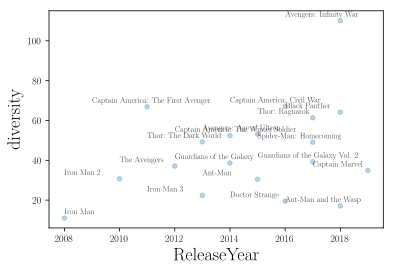

In [362]:
df.plot.scatter(x = 'ReleaseYear', y = 'diversity', alpha = 0.3)
for i, row in df.iterrows():
    if row['Title'] != 'Iron Man':
        plt.annotate(xy=(row['ReleaseYear']-2, row['diversity']+2), s = row['Title'], alpha = 0.8, size = 8)
    else:
        plt.annotate(xy=(row['ReleaseYear'], row['diversity']+2), s = row['Title'], alpha = 0.8, size = 8)
plt.show()